In [2]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [3]:
import scipy.signal as si

In [4]:
import pysm3
import pysm3.units as usm

In [5]:
import skytools

In [6]:
import astropy.units as u 

In [6]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [7]:
#os.environ

In [8]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  209.506 GB
     percent :   58.400 % 
        used :  250.185 GB
        free :  215.456 GB
      active :   12.251 GB
    inactive :  204.141 GB
     buffers :   12.297 MB
      cached :   37.485 GB
      shared :   23.707 GB
        slab :   24.386 GB



0. Read Planck map

In [8]:
NSIDE = 512
lmax = 2*NSIDE

In [10]:
amin2rad = np.pi/(60*180)

fwhm_spsat = 72.8*amin2rad

fwhm_planck = 35*amin2rad

fwhm_planck

bl_spsat = hp.gauss_beam(fwhm=fwhm_spsat,lmax=lmax,pol=True)
bl_planck = hp.gauss_beam(fwhm=fwhm_planck,lmax=lmax,pol=True)


In [11]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates


In [ ]:
#planck_map = hp.read_map(filename='npipe6v20_030_map.fits',field=None)

In [9]:
#planck_noise,head = hp.read_map(filename='npipe6v20_noise_030_mc_00200.fits',field=None, h = True)
#
#head
#
#hp.mollview(planck_noise[2], title="Planck noise I map (galactic)", min = -1e-4,max = 1e-4)
#
#planck2 = hp.smoothing(map_in=planck_noise,fwhm=np.radians(1))
#
#hp.mollview(planck2[2], title="Planck noise I map", min = -1e-4,max = 1e-4)
#
#Create a polarized CMB map
sky = pysm3.Sky(nside=NSIDE, preset_strings=["c1"] )#,"d0","s0"])

sky.components
map_in = sky.get_emission(30*u.GHz)
map_in = map_in.to(usm.K_CMB, equivalencies=usm.cmb_equivalencies(100*u.GHz))




#sky_changeresol = hp.smoothing(map_in=map_30GHz,fwhm=fwhm_spsat,lmax=lmax)



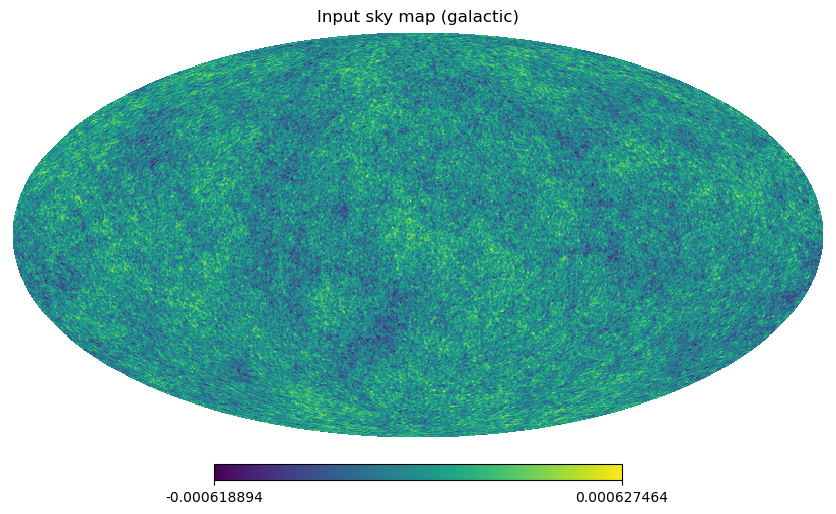

In [11]:
hp.mollview(map_in[0], title="Input sky map (galactic)")


In [12]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [13]:
l_arr = np.arange(0,lmax+1)

In [14]:
Dl_in = D_ell(map_in, lmax = lmax)

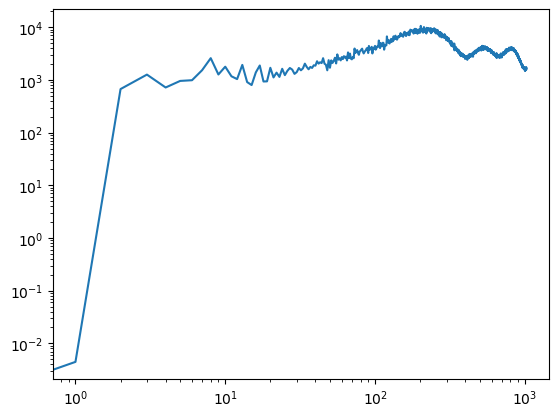

In [16]:
plt.plot(l_arr,Dl_in[0]*1e12)
plt.xscale('log')
plt.yscale('log')
plt.show()

setting the output map dtype to [dtype('float64'), dtype('float64'), dtype('float64')]


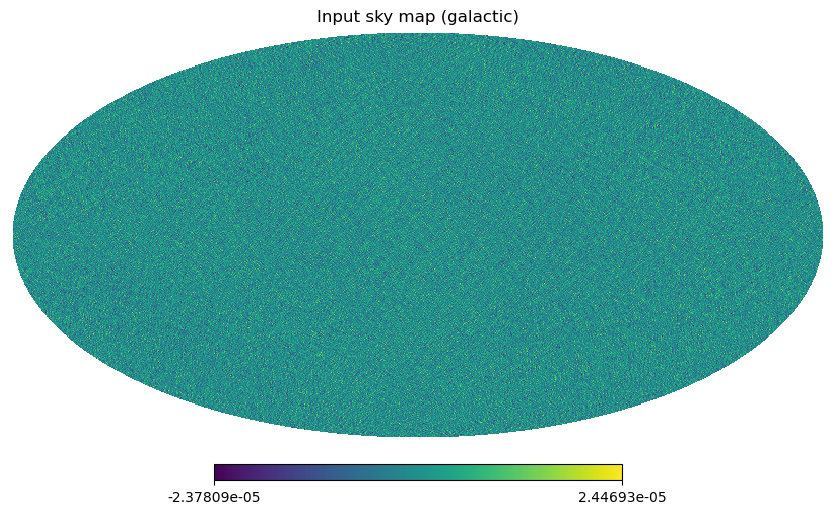

In [13]:
hp.mollview(map_in[2], title="Input sky map (galactic)")
sky_changeresol = hp.smoothing(map_in=map_in,fwhm=fwhm_spsat,lmax=lmax)

sky_changeresol_GC = np.array([rGC.rotate_map_pixel(map) for map in sky_changeresol])
hp.write_map(filename='CMB_030_GC_nside.FITS',m = sky_changeresol_GC, coord = 'C',overwrite=True)

In [14]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [15]:
l_arr = np.arange(0,lmax+1)

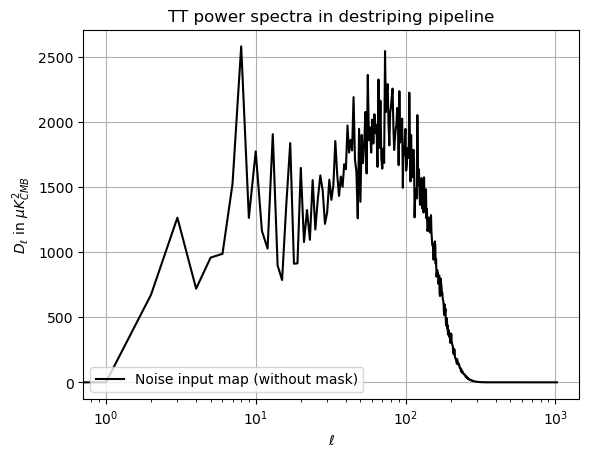

In [19]:
Dl_cmb = D_ell(maps = sky_changeresol_GC,lmax = lmax)
plt.plot(l_arr,Dl_cmb[0]*1e12, 'k-', label = r'Noise input map (without mask)')

plt.xlabel('$\ell$')
plt.ylabel('$D_{\ell}$ in $\mu K_{CMB}^2$')
plt.legend(loc = 'lower left')
plt.xscale('log')
#plt.yscale('log')
plt.title('TT power spectra in destriping pipeline')
#plt.xlim(right = 512)
plt.grid()
#plt.savefig(output_noise+'/cls_comparison'+2*mode_list[i],format = 'svg')
plt.show()


In [ ]:


noise_alm = hp.map2alm(maps=planck_noise,lmax=2*1024)

noise_almchangeresol = np.array([hp.almxfl(noise_alm[i],(bl_spsat/bl_planck)[:,i]) for i in range(3)])

noise_changeresol = hp.alm2map(alms=noise_almchangeresol,nside=NSIDE)

noise_changeresol_GC = np.array([rGC.rotate_map_pixel(map) for map in noise_changeresol])
hp.write_map(filename='noise_030_GC_nside.FITS',m = noise_changeresol_GC, coord = 'C',overwrite=True)

input_tot = sky_changeresol+noise_changeresol
    
print(input_tot.shape)

input_GC = np.array([rGC.rotate_map_pixel(map) for map in input_tot])
hp.mollview(input_GC[0], title="Planck noise I map (equatorial)")

np.where(input_tot!=0)

hp.write_map(filename='skynoise_030_GC_nside.FITS',m = input_GC, coord = 'C',overwrite=True)

In [ ]:
planck_GC512 = hp.read_map(filename='skynoise_030_GC_nside.FITS',field=None)

In [ ]:
planck_GC512.shape

In [ ]:
hp.mollview(planck_GC512[0], title="Input map (equatorial)",min = -3e-3,max = 5e-3)

In [ ]:
noise_GC512 = hp.read_map(filename='noise_030_GC_nside.FITS',field=None)

In [ ]:
hp.mollview(noise_GC512[0], title="Input map (equatorial)")

In [16]:
truesky_GC512 = hp.read_map(filename='CMB_030_GC_nside.FITS',field=None)

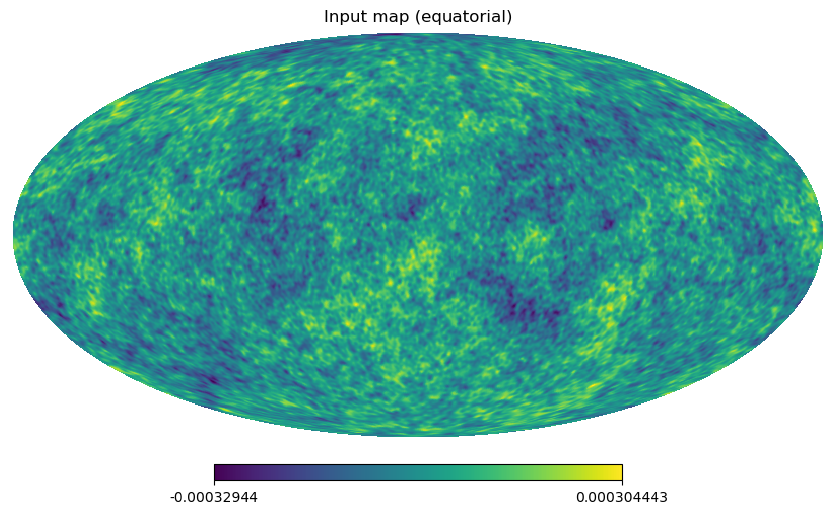

In [18]:
hp.mollview(truesky_GC512[0], title="Input map (equatorial)")

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [19]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

In [20]:
with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

Print focalplane information

In [21]:
focalplane

<Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>

Define the schedule, site and telescope

In [22]:
schedule = toast.schedule.GroundSchedule()
#for i in range(7):
#    schedule.read("POLE_DEEP-169-"+str(i+1)+".txt", comm=comm)
schedule.read("POLE_DEEP-169.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169.txt
TOAST INFO: Loaded 28 scans from POLE_DEEP-169.txt totaling 39.2 hours.


Print schedule information

In [23]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 28 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
  <GroundScan 'POLE_DEEP' at 2027-05-28T07:30:00+00:00 with El = 52.85 deg, Az 41.02 deg -- 111.7 deg>
  ... 
  <GroundScan 'POLE_DEEP' at 2027-05-28T13:30:00+00:00 with El = 53.85 deg, Az 310.76 deg -- 381.45 deg>
  <GroundScan 'POLE_DEEP' at 2027-05-28T15:00:00+00:00 with El = 54.1 deg, Az 288.19 deg -- 358.87 deg>
>

Print telescope information

In [24]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [25]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [26]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [27]:
data = toast.Data(comm=toast_comm)

In [28]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [29]:
sim_ground

<SimGround
  API = 0 # Internal interface version for this operator
  azimuth = azimuth # Observation shared key for Azimuth
  boresight_azel = boresight_azel # Observation shared key for boresight AZ/EL
  boresight_radec = boresight_radec # Observation shared key for boresight RA/DEC
  det_data = signal # Observation detdata key to initialize
  det_data_units = K # Output units if creating detector data
  det_flags = flags # Observation detdata key for flags to initialize
  detset_key = pixel # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  el_mod_amplitude = 1.0 deg # Range of elevation modulation
  el_mod_rate = 0.0 Hz # Modulate elevation continuously at this rate
  el_mod_sine = False # Modulate elevation with a sine wave instead of a triangle wave
  el_mod_step = 0.0 deg # Amount to step elevation after each left-right scan pair
  elevation = e

In [30]:
sim_ground.apply(data)

In [31]:
ob = data.obs[0]
ob.detdata.create(name = 'Planck',units = u.K)


2. Noise simulation

In [32]:
ob.detdata.create(name = 'noise',units = u.K)

In [33]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [34]:
ob.detdata

<DetDataManager 252 local detectors, 50400 samples
    signal: shape=(252, 50400), dtype=float64, units='K'
    flags: shape=(252, 50400), dtype=uint8, units=''
    Planck: shape=(252, 50400), dtype=float64, units='K'
    noise: shape=(252, 50400), dtype=float64, units='K'>

In [35]:
sim_noise.det_data= 'noise'

In [36]:
noise_model.apply(data) ## Read detector noise from the focalplane

In [37]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "IQU")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [38]:
step_0 = 4*u.second


In [39]:
templates = [toast.templates.Offset(name="baselines", step_time = step_0)]

In [40]:
templates

[<Offset
   data = None # This must be an instance of a Data class (or None)
   debug_plots = None # If not None, make debugging plots in this directory
   det_data = signal # Observation detdata key for the timestream data
   det_data_units = K # Desired units of detector data
   det_flag_mask = 7 # Bit mask value for solver flags
   det_flags = flags # Observation detdata key for solver flags to use
   det_mask = 1 # Bit mask value for per-detector flagging
   enabled = True # If True, this class instance is marked as enabled
   good_fraction = 0.5 # Fraction of unflagged samples needed to keep a given offset amplitude
   kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
   name = baselines # The 'name' of this class instance
   noise_model = None # Observation key containing the optional noise model
   precond_width = 20 # Preconditioner width in terms of offsets / baselines
   step_time = 4.0 s # Time per baseline step
   times = times 

In [41]:
template_matrix = toast.ops.TemplateMatrix(templates=templates)

In [42]:
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='skynoise_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='sky_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)
#scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='noise_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='CMB_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)


scan_map.det_data = 'Planck'


In [43]:
scan_map.apply(data)
data

TOAST INFO: Pixel data in CMB_030_GC_nside.FITS does not have TUNIT1 key.  Assuming 'K'.


<Data with 28 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 040_011_SAT_f030_B]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  noise_model = <AnalyticNoise model with 252 detectors>
  50400 total samples (50400 local)
  share

In [44]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 28 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
  <GroundScan 'POLE_DEEP' at 2027-05-28T07:30:00+00:00 with El = 52.85 deg, Az 41.02 deg -- 111.7 deg>
  ... 
  <GroundScan 'POLE_DEEP' at 2027-05-28T13:30:00+00:00 with El = 53.85 deg, Az 310.76 deg -- 381.45 deg>
  <GroundScan 'POLE_DEEP' at 2027-05-28T15:00:00+00:00 with El = 54.1 deg, Az 288.19 deg -- 358.87 deg>
>

How to center data in 0? 
Find the right average?

How does the instrument adjust between detectors? Relative average level for different detectors?

Use a 0-th order polynominial filter to remove average

In [45]:
def filter_0(obs, det_data):
    obs_arr = obs.detdata[det_data]
    obs_arr2 = np.zeros(obs_arr.shape)
    i = 0
    for detec in obs_arr:
        obs_arr2[i] = detec- np.mean(detec)
        i+=1
    obs.detdata[det_data][:,:]  = obs_arr2

In [46]:
time_arr = ob.shared['times'][:]

In [47]:
time_arr.shape

(50400,)

In [48]:
ob.detdata['Planck'][:].shape

(252, 50400)

In [49]:
filter_0(ob,'Planck')
#filter_0(ob,'signal')

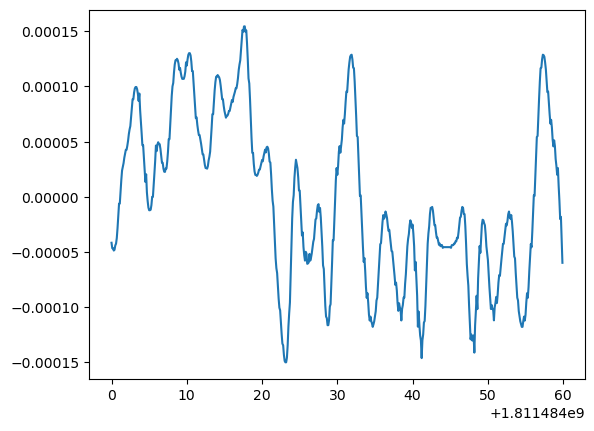

In [50]:
plt.plot(time_arr[0:600],ob.detdata['Planck'][1,0:600])

For each TOD, create a corresponding Mampaker operator, in order to retrieve reconstructed maps independently.

In [51]:
binner = toast.ops.BinMap(pixel_pointing = pixels, stokes_w = weights)
mapmaker = toast.ops.MapMaker(binning = binner, template_matrix=template_matrix)

In [52]:
binner

<BinMap
  API = 0 # Internal interface version for this operator
  binned = binned # The Data key where the binned map should be stored
  covariance = covariance # The Data key containing the noise covariance PixelData instance
  det_data = signal # Observation detdata key for the timestream data
  det_data_units = K # Desired timestream units
  det_flag_mask = 7 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  full_pointing = False # If True, expand pointing for all detectors and save
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = BinMap # The 'name' of this class instance
  noise_model = noise_model # Observation key containing the noise model
  noiseweighted = None # The Data key where the noiseweighted map should be stored
  pixel_dist =

In [53]:
mapmaker.iter_max = 50
#mapmaker.convergence = 1.0e-12
mapmaker.mc_mode = False

#mapmaker

#mapmaker.mc_root = 'root'

In [54]:
mapmaker.mc_mode

False

In [55]:
binner.stokes_weights = weights

In [56]:
output_dir = './cmb_28scan'

In [57]:
binner.det_data = 'Planck'
mapmaker.binning= binner
mapmaker.det_data = 'Planck'
mapmaker.output_dir = output_dir
mapmaker.apply(data)

TOAST INFO: SolveAmplitudes begin building flags for solver
TOAST INFO: SolveAmplitudes  finished flag building in 1.12 s
TOAST INFO: SolveAmplitudes begin build of solver covariance
TOAST INFO: SolveAmplitudes begin build of rcond flags
TOAST INFO: SolveAmplitudes  finished build of solver covariance in 62.16 s
TOAST INFO: SolveAmplitudes Solver flags cut 26235002 / 355622400 = 7.38% of samples
TOAST INFO: SolveAmplitudes begin RHS calculation
TOAST INFO: SolveAmplitudes  finished RHS calculation in 496.95 s
TOAST INFO: SolveAmplitudes begin PCG solver
TOAST INFO: MapMaker initial residual = 1790458758313.5332 in 89.97 s
TOAST INFO: MapMaker iteration    0, relative residual = 5.767768e-03 in 84.97 s
TOAST INFO: MapMaker iteration    1, relative residual = 6.303284e-04 in 151.72 s
TOAST INFO: MapMaker iteration    2, relative residual = 1.718919e-04 in 167.34 s
TOAST INFO: MapMaker iteration    3, relative residual = 7.587906e-05 in 103.05 s
TOAST INFO: MapMaker iteration    4, relati

In [58]:
template_matrix

<TemplateMatrix
  API = 0 # Internal interface version for this operator
  amplitudes = MapMaker_solve_amplitudes # Data key for template amplitudes
  det_data = ApplyAmplitudes_temp # Observation detdata key for the timestream data
  det_data_units = K # Output units if creating detector data
  det_flag_mask = 7 # Bit mask value for detector sample flagging
  det_flags = flags # Observation detdata key for flags to use
  det_mask = 7 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = TemplateMatrix # The 'name' of this class instance
  templates = [<Offset
  data = <Data with 28 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.6499999999999

In [59]:
os.listdir(output_dir)

['MapMaker_rcond.fits',
 'MapMaker_cov.fits',
 'MapMaker_map.fits',
 'MapMaker_hits.fits',
 'MapMaker_binmap.fits']

In [60]:
hitmap_planck = hp.read_map(output_dir+"/MapMaker_hits.fits", dtype = float,field = None)
planck_destriping= hp.read_map(output_dir+"/MapMaker_map.fits", dtype = float,field = None)
planck_rcond= hp.read_map(output_dir+"/MapMaker_rcond.fits", dtype = float,field = None)


In [61]:
planck_rcond= hp.read_map(output_dir+"/MapMaker_rcond.fits", dtype = float,field = None)
log_rcond = np.log(planck_rcond)

/tmp/ipykernel_1553284/557163134.py:2: RuntimeWarning: divide by zero encountered in log
  log_rcond = np.log(planck_rcond)


In [62]:
mask3 = np.zeros(planck_rcond.shape)
mask3[planck_rcond>1e-3]=1

In [63]:
planck_mask = np.zeros(planck_GC512.shape)
planck_mask[:,:] = noise_GC512[:,:]
planck_mask[:,mask3==0] = hp.UNSEEN

NameError: name 'planck_GC512' is not defined

In [ ]:
planck_destriping[:,mask3==0] = hp.UNSEEN

In [ ]:
planck_rcond[mask3==0] = hp.UNSEEN

In [ ]:
hp.gnomview(planck_destriping[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, title = '$\hat{m}_{Planck}$ for destriping pipeline', unit='K_CMB')

In [ ]:
hp.gnomview(planck_rcond,rot = (40,-58),xsize = 1200,ysize=600,reso = 5, title = 'Pixel conditioning', unit='K_CMB')

In [ ]:
hp.gnomview(planck_mask[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, title = '${m}_{Planck}$ input', unit='K_CMB')

In [ ]:
diff_map = planck_destriping-planck_mask
diff_map[:,mask3==0] = hp.UNSEEN
hp.gnomview(diff_map[0],rot = (40,-58),xsize = 1200,ysize=600,reso = 5, title = '$\hat{m}_{Planck}-m_{input}$ for destriping pipeline', unit='K_CMB')

In [ ]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [ ]:
Dl_in = D_ell(maps=planck_mask,lmax=lmax,use_pixel_weights=False)
Dl_out = D_ell(maps=planck_destriping,lmax=lmax)
Dl_diff = D_ell(maps=diff_map,lmax=lmax)

In [ ]:
hit_mask = np.array(np.where(mask3<=0))[0]
sky_fraction = 1-(len(hit_mask) / len(mask3))
print(f"The map covers {sky_fraction:.1%} of the sky")

In [ ]:
l_arr = np.arange(0,lmax+1)

In [ ]:
plt.plot(l_arr,Dl_in[0]*1e12/sky_fraction, 'k-', label = r'$D_{\ell}^{TT}$ for noise input map (with mask)')
plt.plot(l_arr,Dl_out[0]*1e12/sky_fraction, 'b-', label = r'$D_{\ell}^{TT}$ for noise output map')
#plt.plot(l_arr,Dl_2[0]*1e12/sky_fraction, 'g--', label = r'$D_{\ell}^{TT}$ for output map weighted by hits')

#plt.plot(l_arr,Dl_diff[0]*1e12/sky_fraction, 'r.', label = r'$D_{\ell}^{TT}$ for residual map')
plt.xlabel('$\ell$')
plt.ylabel('$\mu K_{CMB}^2$')
plt.legend(loc = 'lower left')
plt.xscale('log')
plt.yscale('log')
plt.title('Noise loss with destriping pipeline')
plt.grid()
plt.savefig(output_dir+'/cls_comparison',format = 'svg')
plt.show()

In [ ]:
np.savez(output_dir+"/dls", dl_in = Dl_in, dl_out = Dl_out, dl_diff = Dl_diff )

In [ ]:
os.listdir(output_dir)

In [ ]:
output_dir